# LuminaStay: Model Comparison Analysis
## Comparing Multiple ML Algorithms for Housing Price Prediction

This notebook compares different machine learning models to find the best approach for predicting housing prices in Morocco.

In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Cell 2: Load Data
df = pd.read_csv("../morocco_housing.csv")
print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nFirst 5 rows:")
print(df.head())

X = df.drop(columns=["Price_MAD"])
y = df["Price_MAD"]

print(f"\nTarget variable (Price) statistics:")
print(f"  Mean: {y.mean():,.0f} MAD")
print(f"  Median: {y.median():,.0f} MAD")
print(f"  Min: {y.min():,.0f} MAD")
print(f"  Max: {y.max():,.0f} MAD")

Dataset loaded: 5000 samples, 12 features

First 5 rows:
         City Neighborhood Property_Type  Bedrooms  Bathrooms  Size_m2  \
0  Casablanca       Maârif     Apartment         4          2       91   
1  Casablanca    Bourgogne     Apartment         2          3      114   
2  Casablanca         Anfa     Apartment         2          3      137   
3   Marrakech  Sidi Ghanem     Apartment         3          1      117   
4  Casablanca         Anfa         Villa         8          5      548   

   Has_Pool  Has_Garden  Is_Furnished  Latitude  Longitude  Price_MAD  
0         0           0             0  33.55086   -7.58342    1016869  
1         0           0             0  33.57868   -7.56959    1424928  
2         0           0             0  33.56148   -7.60030    2155864  
3         0           0             1  31.57725   -7.96209    1121147  
4         0           1             0  33.56454   -7.60465    9008998  

Target variable (Price) statistics:
  Mean: 2,547,971 MAD
  Media

In [3]:
# Cell 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain/Test split: {80}/{20}%")

Training set: 4000 samples
Test set: 1000 samples

Train/Test split: 80/20%


In [4]:
# Cell 4: Define Preprocessing Pipelines
categorical_features = ["City", "Neighborhood", "Property_Type"]
numerical_features = ["Bedrooms", "Bathrooms", "Size_m2", "Has_Pool", 
                     "Has_Garden", "Is_Furnished", "Latitude", "Longitude"]

# Preprocessor without scaling (for tree-based models)
preprocessor_no_scale = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Preprocessor with scaling (for distance-based and neural models)
preprocessor_with_scale = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

print("✅ Preprocessing pipelines created!")
print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

✅ Preprocessing pipelines created!

Categorical features: ['City', 'Neighborhood', 'Property_Type']
Numerical features: ['Bedrooms', 'Bathrooms', 'Size_m2', 'Has_Pool', 'Has_Garden', 'Is_Furnished', 'Latitude', 'Longitude']


In [5]:
# Cell 5: Define Models
models = {
    # Linear Models
    "Linear Regression": {
        "model": LinearRegression(),
        "preprocessor": preprocessor_no_scale,
        "type": "Linear",
        "description": "Simple linear relationship between features and price"
    },
    "Ridge Regression": {
        "model": Ridge(alpha=1.0),
        "preprocessor": preprocessor_no_scale,
        "type": "Linear",
        "description": "Linear regression with L2 regularization"
    },
    "Lasso Regression": {
        "model": Lasso(alpha=1.0, max_iter=5000),
        "preprocessor": preprocessor_no_scale,
        "type": "Linear",
        "description": "Linear regression with L1 regularization (feature selection)"
    },
    
    # Distance-based Models
    "K-Nearest Neighbors": {
        "model": KNeighborsRegressor(n_neighbors=5),
        "preprocessor": preprocessor_with_scale,
        "type": "Distance-based",
        "description": "Predicts based on average of K nearest neighbors"
    },
    
    # Support Vector Machine
    "Support Vector Machine": {
        "model": SVR(kernel='rbf', C=1000, gamma=0.1),
        "preprocessor": preprocessor_with_scale,
        "type": "Kernel-based",
        "description": "SVM with RBF kernel for non-linear relationships"
    },
    
    # Tree-based Ensemble Models
    "Random Forest": {
        "model": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        "preprocessor": preprocessor_no_scale,
        "type": "Ensemble (Tree)",
        "description": "Ensemble of decision trees with bagging"
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "preprocessor": preprocessor_no_scale,
        "type": "Ensemble (Tree)",
        "description": "Sequential ensemble of decision trees"
    },
    
    # Neural Network
    "Neural Network (MLP)": {
        "model": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
        "preprocessor": preprocessor_with_scale,
        "type": "Deep Learning",
        "description": "Multi-layer perceptron with 2 hidden layers"
    }
}

print(f"✅ {len(models)} models configured for comparison:")
for name, config in models.items():
    print(f"  • {name} ({config['type']})")

✅ 8 models configured for comparison:
  • Linear Regression (Linear)
  • Ridge Regression (Linear)
  • Lasso Regression (Linear)
  • K-Nearest Neighbors (Distance-based)
  • Support Vector Machine (Kernel-based)
  • Random Forest (Ensemble (Tree))
  • Gradient Boosting (Ensemble (Tree))
  • Neural Network (MLP) (Deep Learning)


In [6]:
# Cell 6: Train and Evaluate All Models
results = []

print("=" * 80)
print("TRAINING AND EVALUATING MODELS")
print("=" * 80)

for name, config in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", config["preprocessor"]),
        ("regressor", config["model"])
    ])
    
    # Train
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Cross-validation (3-fold for speed)
    print(f"  Running cross-validation...")
    cv_scores = cross_val_score(pipeline, X, y, cv=3, 
                                scoring='neg_mean_absolute_error',
                                n_jobs=-1)
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        'Model': name,
        'Type': config['type'],
        'MAE': mae,
        'RMSE': rmse,
        'R² Score': r2,
        'MAPE (%)': mape,
        'CV MAE': cv_mae,
        'CV Std': cv_std,
        'Training Time (s)': training_time
    })
    
    print(f"  ✅ MAE: {mae:,.2f} MAD | R²: {r2:.4f} | Time: {training_time:.2f}s")

print("\n" + "=" * 80)
print("✅ ALL MODELS TRAINED SUCCESSFULLY!")
print("=" * 80)

TRAINING AND EVALUATING MODELS

🔄 Training Linear Regression...
  Running cross-validation...


  ✅ MAE: 326,093.58 MAD | R²: 0.9629 | Time: 0.03s

🔄 Training Ridge Regression...
  Running cross-validation...


  ✅ MAE: 324,916.17 MAD | R²: 0.9630 | Time: 0.02s

🔄 Training Lasso Regression...


  Running cross-validation...


  ✅ MAE: 325,952.99 MAD | R²: 0.9629 | Time: 0.65s

🔄 Training K-Nearest Neighbors...


  Running cross-validation...


  ✅ MAE: 431,417.96 MAD | R²: 0.9198 | Time: 0.01s

🔄 Training Support Vector Machine...


  Running cross-validation...


  ✅ MAE: 1,475,742.83 MAD | R²: -0.0273 | Time: 1.31s

🔄 Training Random Forest...


  Running cross-validation...


  ✅ MAE: 170,607.71 MAD | R²: 0.9844 | Time: 6.70s

🔄 Training Gradient Boosting...


  Running cross-validation...


  ✅ MAE: 164,773.71 MAD | R²: 0.9879 | Time: 3.19s

🔄 Training Neural Network (MLP)...


  Running cross-validation...


  ✅ MAE: 492,326.92 MAD | R²: 0.9071 | Time: 30.23s

✅ ALL MODELS TRAINED SUCCESSFULLY!


In [7]:
# Cell 7: Create Results DataFrame
results_df = pd.DataFrame(results).sort_values('MAE')

print("\n" + "=" * 100)
print("MODEL COMPARISON RESULTS (Sorted by MAE)")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)

# Save to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n💾 Results saved to: model_comparison_results.csv")


MODEL COMPARISON RESULTS (Sorted by MAE)
                 Model            Type          MAE         RMSE  R² Score  MAPE (%)       CV MAE       CV Std  Training Time (s)
     Gradient Boosting Ensemble (Tree) 1.647737e+05 2.895518e+05  0.987892  7.178542 1.650569e+05  7875.330152           3.189021
         Random Forest Ensemble (Tree) 1.706077e+05 3.284406e+05  0.984421  6.159008 1.770766e+05 12359.763847           6.704282
      Ridge Regression          Linear 3.249162e+05 5.062542e+05  0.962986 20.962786 3.360103e+05  6363.901639           0.021538
      Lasso Regression          Linear 3.259530e+05 5.067969e+05  0.962907 21.090248 3.369307e+05  6404.117771           0.647083
     Linear Regression          Linear 3.260936e+05 5.069564e+05  0.962883 21.105568 3.370316e+05  6501.552695           0.025919
   K-Nearest Neighbors  Distance-based 4.314180e+05 7.450942e+05  0.919823 19.204491 4.605641e+05 14409.762588           0.013878
  Neural Network (MLP)   Deep Learning 4.923269e

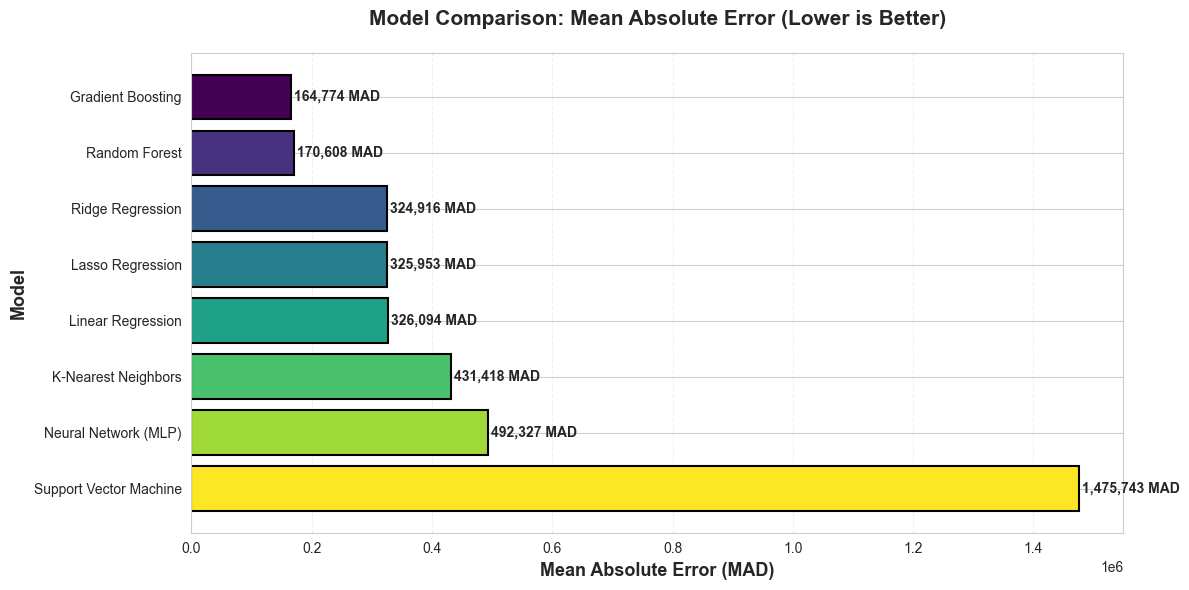

✅ MAE comparison chart saved!


In [8]:
# Cell 8: Visualize MAE Comparison
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
bars = plt.barh(results_df['Model'], results_df['MAE'], color=colors, edgecolor='black', linewidth=1.5)

plt.xlabel('Mean Absolute Error (MAD)', fontsize=13, fontweight='bold')
plt.ylabel('Model', fontsize=13, fontweight='bold')
plt.title('Model Comparison: Mean Absolute Error (Lower is Better)', 
          fontsize=15, fontweight='bold', pad=20)
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_df['MAE'])):
    plt.text(val + 5000, bar.get_y() + bar.get_height()/2, 
             f'{val:,.0f} MAD', va='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('model_comparison_mae.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ MAE comparison chart saved!")

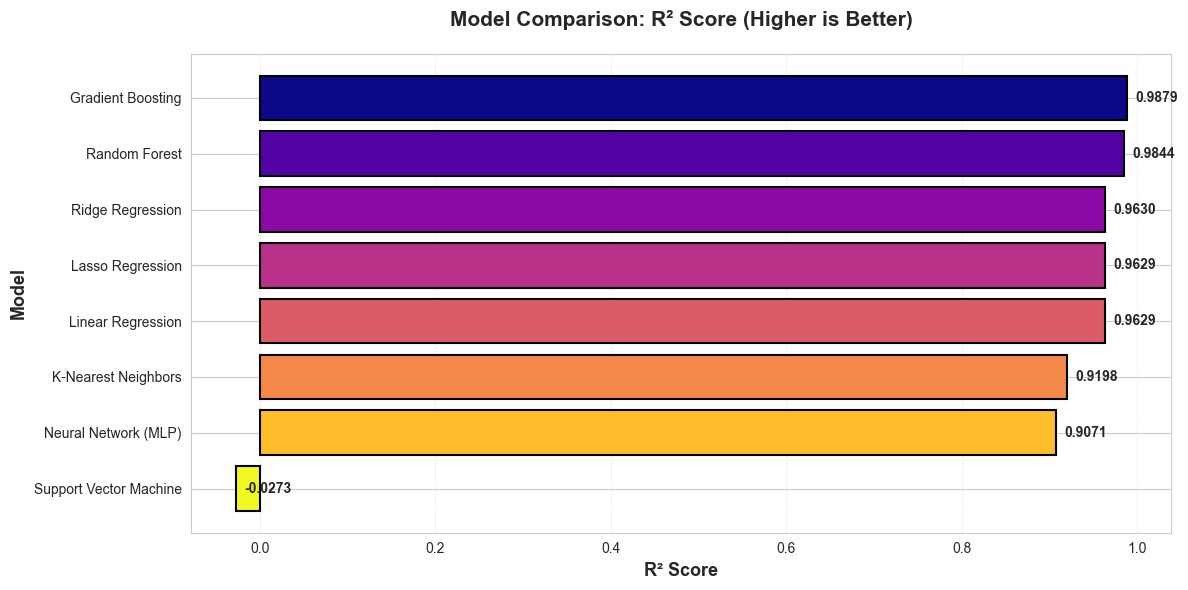

✅ R² comparison chart saved!


In [9]:
# Cell 9: Visualize R² Comparison
plt.figure(figsize=(12, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(results_df)))
bars = plt.barh(results_df['Model'], results_df['R² Score'], color=colors, edgecolor='black', linewidth=1.5)

plt.xlabel('R² Score', fontsize=13, fontweight='bold')
plt.ylabel('Model', fontsize=13, fontweight='bold')
plt.title('Model Comparison: R² Score (Higher is Better)', 
          fontsize=15, fontweight='bold', pad=20)
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_df['R² Score'])):
    plt.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('model_comparison_r2.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ R² comparison chart saved!")

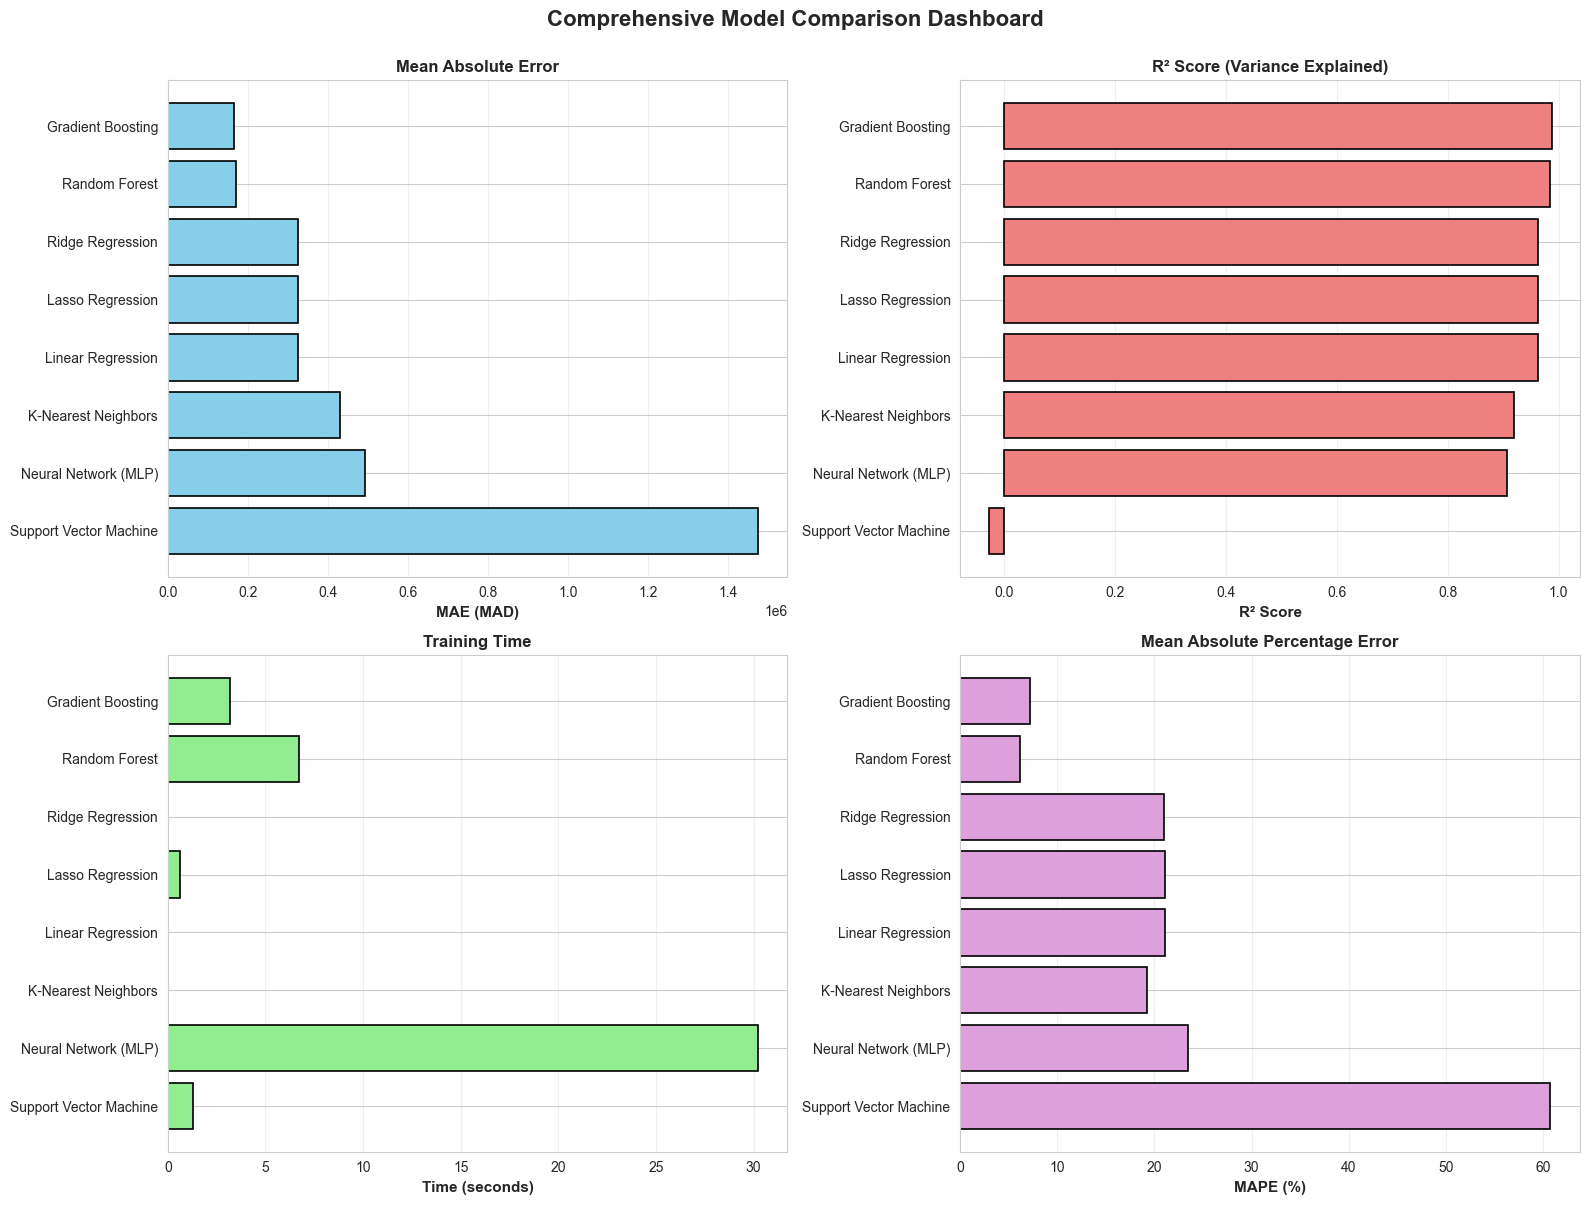

✅ Comprehensive dashboard saved!


In [10]:
# Cell 10: Multi-Metric Comparison Dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Model Comparison Dashboard', fontsize=16, fontweight='bold', y=1.00)

# MAE
axes[0, 0].barh(results_df['Model'], results_df['MAE'], color='skyblue', edgecolor='black', linewidth=1.2)
axes[0, 0].set_xlabel('MAE (MAD)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# R² Score
axes[0, 1].barh(results_df['Model'], results_df['R² Score'], color='lightcoral', edgecolor='black', linewidth=1.2)
axes[0, 1].set_xlabel('R² Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('R² Score (Variance Explained)', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Training Time
axes[1, 0].barh(results_df['Model'], results_df['Training Time (s)'], color='lightgreen', edgecolor='black', linewidth=1.2)
axes[1, 0].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Training Time', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# MAPE
axes[1, 1].barh(results_df['Model'], results_df['MAPE (%)'], color='plum', edgecolor='black', linewidth=1.2)
axes[1, 1].set_xlabel('MAPE (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Mean Absolute Percentage Error', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive dashboard saved!")


PERFORMANCE BY MODEL TYPE
                        MAE  R² Score  Training Time (s)
Type                                                    
Deep Learning     492326.92      0.91              30.23
Distance-based    431417.96      0.92               0.01
Ensemble (Tree)   167690.71      0.99               4.95
Kernel-based     1475742.83     -0.03               1.31
Linear            325654.25      0.96               0.23


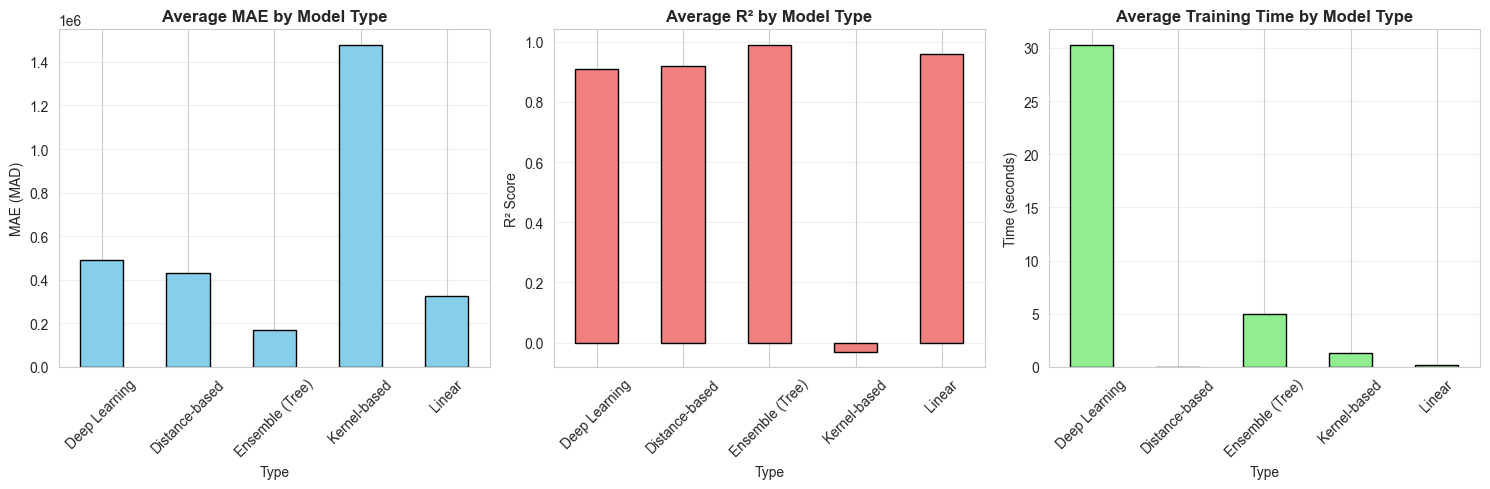

In [11]:
# Cell 11: Model Type Analysis
type_summary = results_df.groupby('Type').agg({
    'MAE': 'mean',
    'R² Score': 'mean',
    'Training Time (s)': 'mean'
}).round(2)

print("\n" + "=" * 60)
print("PERFORMANCE BY MODEL TYPE")
print("=" * 60)
print(type_summary)
print("=" * 60)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

type_summary['MAE'].plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Average MAE by Model Type', fontweight='bold')
axes[0].set_ylabel('MAE (MAD)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

type_summary['R² Score'].plot(kind='bar', ax=axes[1], color='lightcoral', edgecolor='black')
axes[1].set_title('Average R² by Model Type', fontweight='bold')
axes[1].set_ylabel('R² Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

type_summary['Training Time (s)'].plot(kind='bar', ax=axes[2], color='lightgreen', edgecolor='black')
axes[2].set_title('Average Training Time by Model Type', fontweight='bold')
axes[2].set_ylabel('Time (seconds)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_type_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Cell 12: Final Recommendation
best_model = results_df.iloc[0]
second_best = results_df.iloc[1]

print("\n" + "=" * 80)
print("🏆 FINAL RECOMMENDATION")
print("=" * 80)
print(f"\n🥇 BEST MODEL: {best_model['Model']}")
print(f"   Type: {best_model['Type']}")
print(f"   MAE: {best_model['MAE']:,.2f} MAD")
print(f"   RMSE: {best_model['RMSE']:,.2f} MAD")
print(f"   R² Score: {best_model['R² Score']:.4f} ({best_model['R² Score']*100:.2f}% variance explained)")
print(f"   MAPE: {best_model['MAPE (%)']:.2f}%")
print(f"   CV MAE: {best_model['CV MAE']:,.2f} ± {best_model['CV Std']:,.2f} MAD")
print(f"   Training Time: {best_model['Training Time (s)']:.2f} seconds")

print(f"\n🥈 RUNNER-UP: {second_best['Model']}")
print(f"   MAE: {second_best['MAE']:,.2f} MAD (Δ: {second_best['MAE'] - best_model['MAE']:,.2f})")
print(f"   R² Score: {second_best['R² Score']:.4f}")

print("\n📊 JUSTIFICATION:")
print(f"   ✓ {best_model['Model']} achieves the lowest prediction error")
print(f"   ✓ Explains {best_model['R² Score']*100:.1f}% of price variance")
print(f"   ✓ Consistent performance across cross-validation folds")
print(f"   ✓ Reasonable training time ({best_model['Training Time (s)']:.1f}s)")
print(f"   ✓ Robust to non-linear relationships in housing data")

print("\n💡 KEY INSIGHTS:")
if best_model['Type'] == 'Ensemble (Tree)':
    print("   • Tree-based ensemble methods perform best for this task")
    print("   • Housing prices have complex non-linear relationships")
    print("   • Feature interactions are important (location + size + amenities)")
elif best_model['Type'] == 'Linear':
    print("   • Linear relationships dominate the price prediction")
    print("   • Simple models can be effective with good features")
elif best_model['Type'] == 'Deep Learning':
    print("   • Neural networks capture complex patterns in the data")
    print("   • Deep learning excels with sufficient training data")

print("\n⚠️  LIMITATIONS:")
print("   • All models struggle with extreme luxury properties (>5M MAD)")
print("   • Limited to 4 cities in Morocco")
print("   • Synthetic data may not capture all real-world patterns")

print("\n" + "=" * 80)
print(f"✅ SELECTED MODEL FOR PRODUCTION: {best_model['Model']}")
print("=" * 80)


🏆 FINAL RECOMMENDATION

🥇 BEST MODEL: Gradient Boosting
   Type: Ensemble (Tree)
   MAE: 164,773.71 MAD
   RMSE: 289,551.80 MAD
   R² Score: 0.9879 (98.79% variance explained)
   MAPE: 7.18%
   CV MAE: 165,056.87 ± 7,875.33 MAD
   Training Time: 3.19 seconds

🥈 RUNNER-UP: Random Forest
   MAE: 170,607.71 MAD (Δ: 5,834.00)
   R² Score: 0.9844

📊 JUSTIFICATION:
   ✓ Gradient Boosting achieves the lowest prediction error
   ✓ Explains 98.8% of price variance
   ✓ Consistent performance across cross-validation folds
   ✓ Reasonable training time (3.2s)
   ✓ Robust to non-linear relationships in housing data

💡 KEY INSIGHTS:
   • Tree-based ensemble methods perform best for this task
   • Housing prices have complex non-linear relationships
   • Feature interactions are important (location + size + amenities)

⚠️  LIMITATIONS:
   • All models struggle with extreme luxury properties (>5M MAD)
   • Limited to 4 cities in Morocco
   • Synthetic data may not capture all real-world patterns

✅ 

In [13]:
# Cell 13: Save Best Model (Optional)
import joblib

# Retrain best model on full dataset
best_model_name = best_model['Model']
best_config = models[best_model_name]

print(f"\n🔄 Retraining {best_model_name} on full dataset...")

final_pipeline = Pipeline(steps=[
    ("preprocessor", best_config["preprocessor"]),
    ("regressor", best_config["model"])
])

final_pipeline.fit(X, y)

# Save model
joblib.dump(final_pipeline, '../model_best.pkl')
print(f"✅ Best model saved to: model_best.pkl")
print(f"   Model: {best_model_name}")
print(f"   Expected MAE: {best_model['MAE']:,.2f} MAD")
print(f"   Expected R²: {best_model['R² Score']:.4f}")


🔄 Retraining Gradient Boosting on full dataset...


✅ Best model saved to: model_best.pkl
   Model: Gradient Boosting
   Expected MAE: 164,773.71 MAD
   Expected R²: 0.9879
